✅ Loaded and handled initial missing values for 4920 rows.
⚠️ WARNING: 4920 NaNs found in final feature set (X). Imputing with mean/0.
✅ Data split into train/test sets. NaN check passed.

--- 1. Support Vector Regression (SVR) ---
📊 R-squared (R²): 0.9915


✅ INITIAL / PARTIAL RESULTS SUMMARY & GRAPHS
📊 Comprehensive Model Performance Summary:
| Metric          |   Value | Model Type              |
|:----------------|--------:|:------------------------|
| R-squared (R²)  |  0.9915 | SVR (Regression)        |
| MSE             |  1.1949 | SVR (Regression)        |
| RMSE            |  1.0931 | SVR (Regression)        |
| SVM Accuracy    |  1.0000 | SVC (Classification)    |
| LogReg Accuracy |  1.0000 | LogReg (Classification) |


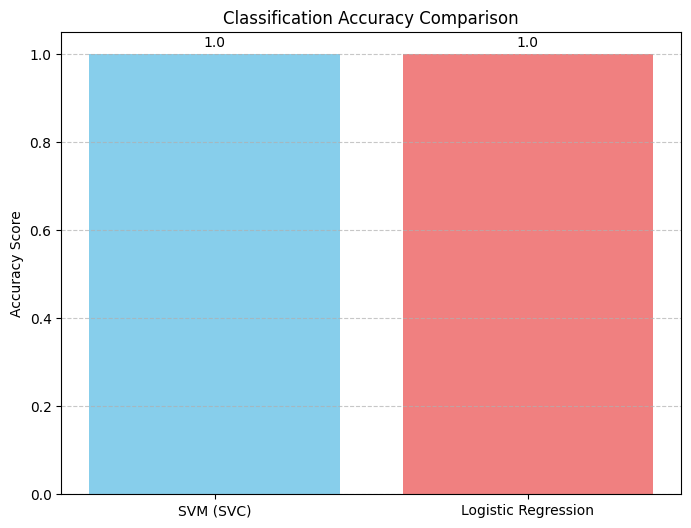

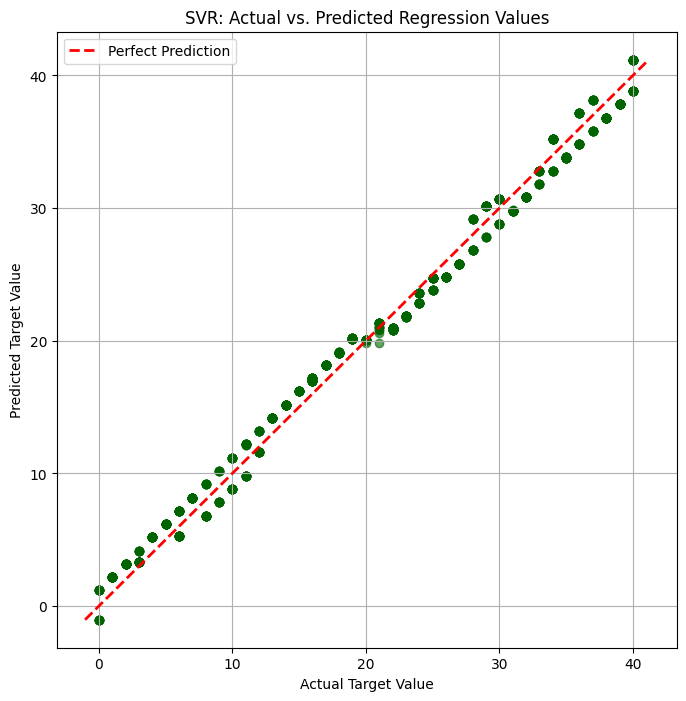

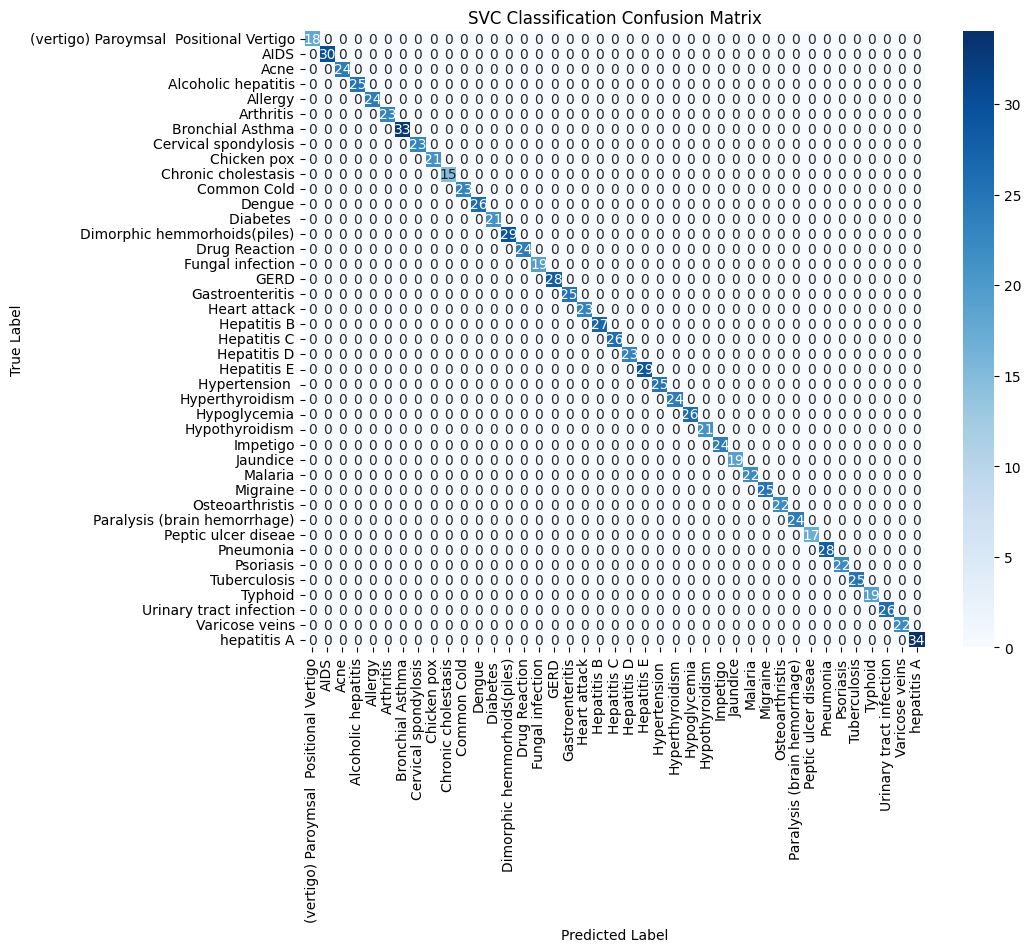


✅ All steps completed successfully!


In [4]:
# =======================================================
# FULL ML SCRIPT WITH 3 GRAPHS: ACCURACY BAR, ACTUAL vs. PREDICTED, CONFUSION MATRIX
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
import os
import seaborn as sns # Added for nicer confusion matrix

# --- Configuration ---
DATASET_PATH = os.path.join(os.getcwd(), "dataset", "Training.csv")
TARGET_COLUMN = 'prognosis'
RANDOM_STATE = 42

# --------------------------------
# Step 1: Load and Initial Preprocessing
# --------------------------------
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ {DATASET_PATH} not found. Please ensure 'Training.csv' is in a 'dataset' folder.")

df = pd.read_csv(DATASET_PATH)
df = df.ffill().bfill() # Initial imputation of original NaNs
print(f"✅ Loaded and handled initial missing values for {df.shape[0]} rows.")

# --------------------------------------------
# Step 2: Prepare Target for BOTH Tasks
# --------------------------------------------

# 2a. CLASSIFICATION TARGET (y_class)
target_le = LabelEncoder()
y_class = target_le.fit_transform(df[TARGET_COLUMN])

# 2b. REGRESSION TARGET (y_reg): Numerical, continuous value is assumed.
y_reg = df[TARGET_COLUMN].copy()
if y_reg.dtype == 'object':
    y_reg = pd.Series(target_le.transform(y_reg), index=y_reg.index)
y_reg = pd.to_numeric(y_reg, errors='coerce').fillna(y_reg.mean()) # Fill NaNs

# 2c. FEATURES (X): Encode all features
X = df.drop(columns=[TARGET_COLUMN])
le_feature = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le_feature.fit_transform(X[col].astype(str))
    elif pd.api.types.is_numeric_dtype(X[col]) == False:
         X[col] = pd.to_numeric(X[col], errors='coerce')

# --------------------------------
# Step 3: Final Imputation and Scaling
# --------------------------------

# CRITICAL FIX: Ensure no NaNs remain in X after encoding/coercion
initial_nan_count = X.isnull().sum().sum()
if initial_nan_count > 0:
    print(f"⚠️ WARNING: {initial_nan_count} NaNs found in final feature set (X). Imputing with mean/0.")
    X = X.fillna(X.mean(numeric_only=True)).fillna(0)
    
# Scale Features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split X, y_reg, and y_class consistently
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X_scaled, y_reg, y_class, test_size=0.2, random_state=RANDOM_STATE
)
print(f"✅ Data split into train/test sets. NaN check passed.")


# =======================================================
# PART A: REGRESSION METRICS (SVR)
# =======================================================
print("\n--- 1. Support Vector Regression (SVR) ---")
scaler_y = StandardScaler()
y_reg_train_scaled = scaler_y.fit_transform(y_reg_train.values.reshape(-1, 1)).ravel()
svr = SVR(kernel='rbf', C=10, gamma=0.1) 
svr.fit(X_train, y_reg_train_scaled)

y_pred_reg_scaled = svr.predict(X_test)
y_pred_reg = scaler_y.inverse_transform(y_pred_reg_scaled.reshape(-1, 1)).ravel()

r2 = r2_score(y_reg_test, y_pred_reg)
mse = mean_squared_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mse)
print(f"📊 R-squared (R²): {r2:.4f}")

# =======================================================
# PART B: CLASSIFICATION METRICS (SVC & LogReg)
# =======================================================

# --- 2. Support Vector Machine (SVC) Classification ---
svc = SVC(kernel='rbf', C=10, gamma=0.1, random_state=RANDOM_STATE)
svc.fit(X_train, y_class_train)
y_pred_class_svm = svc.predict(X_test)
svm_accuracy = accuracy_score(y_class_test, y_pred_class_svm)

# --- 3. Logistic Regression Classification ---
log_reg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
log_reg.fit(X_train, y_class_train)
y_pred_class_log_reg = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_class_test, y_pred_class_log_reg)


# =======================================================
# PART C: INITIAL / PARTIAL RESULTS (Summary & Graphs)
# =======================================================

print("\n\n=======================================================")
print("✅ INITIAL / PARTIAL RESULTS SUMMARY & GRAPHS")
print("=======================================================")

# --- 1. Summary Table ---
results_summary = pd.DataFrame({
    'Metric': ['R-squared (R²)', 'MSE', 'RMSE', 'SVM Accuracy', 'LogReg Accuracy'],
    'Value': [r2, mse, rmse, svm_accuracy, log_reg_accuracy],
    'Model Type': ['SVR (Regression)', 'SVR (Regression)', 'SVR (Regression)', 
                   'SVC (Classification)', 'LogReg (Classification)'],
})
print("📊 Comprehensive Model Performance Summary:")
print(results_summary.to_markdown(index=False, floatfmt=".4f")) 


# --------------------------------------
# 2. Graph 1: Classification Accuracy Comparison (Bar Chart)
# --------------------------------------
plt.figure(figsize=(8, 6))
model_names = ['SVM (SVC)', 'Logistic Regression']
accuracies = [svm_accuracy, log_reg_accuracy]
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Accuracy Score')
plt.title('Classification Accuracy Comparison')
plt.ylim(0, 1.05) 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --------------------------------------
# 3. Graph 2: Regression Actual vs. Predicted (Scatter Plot)
# --------------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(y_reg_test, y_pred_reg, color='darkgreen', alpha=0.6)
# Add a perfect prediction line (y=x)
min_val = min(y_reg_test.min(), y_pred_reg.min())
max_val = max(y_reg_test.max(), y_pred_reg.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.title('SVR: Actual vs. Predicted Regression Values')
plt.xlabel('Actual Target Value')
plt.ylabel('Predicted Target Value')
plt.legend()
plt.grid(True)
plt.show()


# --------------------------------------
# 4. Graph 3: SVC Confusion Matrix (Heatmap)
# --------------------------------------
cm = confusion_matrix(y_class_test, y_pred_class_svm)
plt.figure(figsize=(10, 8))
# Get original class names for axis labels
class_names = target_le.classes_ 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('SVC Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n✅ All steps completed successfully!")